In [1]:
pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [20]:
import os
import numpy as np
import librosa
import logging
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [21]:

# Setup logging
logging.basicConfig(filename='processing_errors.log', level=logging.ERROR)

In [22]:
# Paths
dataset_path = os.path.normpath(r"C:/Users/ishit/OneDrive/Desktop/Bbay_cry/donateacry_corpus")  # Update this path

In [23]:
# Define categories
categories = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']

In [24]:
# Feature extraction function
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12)
    zcr = librosa.feature.zero_crossing_rate(y)
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=6, fmin=50)
    spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    rms = librosa.feature.rms(y=y)
    
      # Aggregate features
    features = np.hstack([
        np.mean(mfccs, axis=1),
        np.mean(chroma, axis=1),
        np.mean(zcr),
        np.mean(spec_contrast, axis=1),
        np.mean(spec_rolloff),
        np.mean(spec_centroid),
        np.mean(rms)
    ])
    
    return features


In [25]:
# Prepare data
def prepare_data():
    features = []
    labels = []
    for category in categories:
        folder_path = os.path.join(dataset_path, category)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(folder_path, file_name)
                try:
                    feature = extract_features(file_path)
                    features.append(feature)
                    labels.append(category)
                except Exception as e:
                    logging.error(f"Error processing file {file_path}: {e}")
    return np.array(features), np.array(labels)



In [26]:
# Load data
X, y = prepare_data()


In [27]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


In [28]:
# Handle imbalanced data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)


In [29]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [30]:
# Create a pipeline for scaling and training with hyperparameter tuning
clf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=42, class_weight='balanced')
)

In [31]:
param_grid = {
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [10, 15, 20],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
}

In [32]:
grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [10, 15, 20],
                         'randomforestclassifier__min_samples_leaf': [1, 2, 4],
                         'randomforestclassifier__min_samples_split': [2, 5,
                                                                       10],
                         'randomforestclassifier__n_estimators': [100, 200,
                                                                  300]},
             verbose=2)

In [33]:
# Use best model
best_clf = grid_search.best_estimator_

In [34]:
# Predict and evaluate
y_pred = best_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

In [35]:
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Weighted F1 Score: {f1:.2f}')
print(classification_report(y_test, y_pred, target_names=categories))

Accuracy: 97.12%
Weighted F1 Score: 0.97
              precision    recall  f1-score   support

  belly_pain       0.99      0.97      0.98        73
     burping       0.95      1.00      0.97        72
  discomfort       0.96      0.99      0.98        80
      hungry       0.99      0.90      0.94        84
       tired       0.97      1.00      0.99        73

    accuracy                           0.97       382
   macro avg       0.97      0.97      0.97       382
weighted avg       0.97      0.97      0.97       382



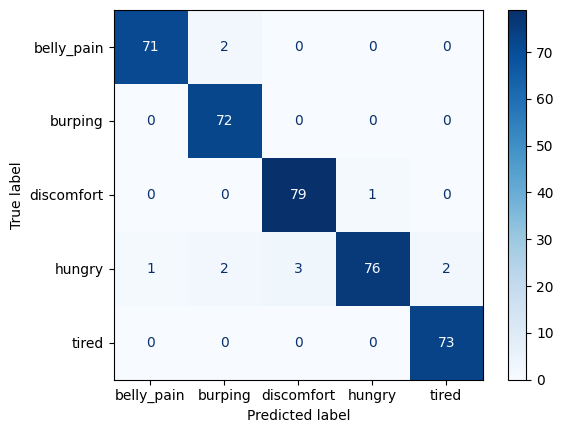

In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [37]:
# Function to predict
def predict_audio(file_paths):
    if isinstance(file_paths, str):  # single file
        file_paths = [file_paths]
    predictions = {}
    for file_path in file_paths:
        feature = extract_features(file_path)
        feature = feature.reshape(1, -1)  # Reshape for a single sample
        prediction = best_clf.predict(feature)
        predictions[file_path] = label_encoder.inverse_transform(prediction)[0]
    return predictions

In [38]:
# User-defined input for file path
test_files = input("Please enter the path(s) of the audio file(s) you want to predict (comma-separated): ").strip('\"')
test_files = [fp.strip() for fp in test_files.split(',')]
predictions = predict_audio(test_files)
for file, pred in predictions.items():
    print(f'The reason behind the baby cry in {file} is: {pred}')

The reason behind the baby cry in C:\Users\ishit\OneDrive\Desktop\Bbay_cry\donateacry_corpus\burping\5afc6a14-a9d8-45f8-b31d-c79dd87cc8c6-1430757039803-1.7-m-48-bu.wav is: burping


Entire code 

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Accuracy: 97.12%
Weighted F1 Score: 0.97
              precision    recall  f1-score   support

  belly_pain       0.99      0.97      0.98        73
     burping       0.95      1.00      0.97        72
  discomfort       0.96      0.99      0.98        80
      hungry       0.99      0.90      0.94        84
       tired       0.97      1.00      0.99        73

    accuracy                           0.97       382
   macro avg       0.97      0.97      0.97       382
weighted avg       0.97      0.97      0.97       382



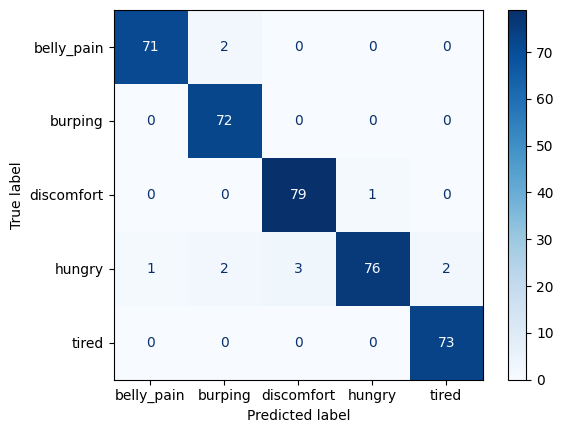

The reason behind the baby cry in C:\Users\ishit\OneDrive\Desktop\Bbay_cry\donateacry_corpus\discomfort\7b0e160e-0505-459e-8ecb-304d7afae9d2-1437486974312-1.7-m-04-dc.wav is: discomfort


In [6]:
import os
import numpy as np
import librosa
import logging
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Setup logging
logging.basicConfig(filename='processing_errors.log', level=logging.ERROR)

# Paths
dataset_path = os.path.normpath(r"C:/Users/ishit/OneDrive/Desktop/Bbay_cry/donateacry_corpus")  # Update this path

# Define categories
categories = ['belly_pain', 'burping', 'discomfort', 'hungry', 'tired']

# Feature extraction function
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12)
    zcr = librosa.feature.zero_crossing_rate(y)
    spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_bands=6, fmin=50)
    spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    rms = librosa.feature.rms(y=y)
    
    # Aggregate features
    features = np.hstack([
        np.mean(mfccs, axis=1),
        np.mean(chroma, axis=1),
        np.mean(zcr),
        np.mean(spec_contrast, axis=1),
        np.mean(spec_rolloff),
        np.mean(spec_centroid),
        np.mean(rms)
    ])
    
    return features

# Prepare data
def prepare_data():
    features = []
    labels = []
    for category in categories:
        folder_path = os.path.join(dataset_path, category)
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(folder_path, file_name)
                try:
                    feature = extract_features(file_path)
                    features.append(feature)
                    labels.append(category)
                except Exception as e:
                    logging.error(f"Error processing file {file_path}: {e}")
    return np.array(features), np.array(labels)

# Load data
X, y = prepare_data()

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Handle imbalanced data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Create a pipeline for scaling and training with hyperparameter tuning
clf = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=42, class_weight='balanced')
)

param_grid = {
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [10, 15, 20],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Use best model
best_clf = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Weighted F1 Score: {f1:.2f}')
print(classification_report(y_test, y_pred, target_names=categories))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Function to predict
def predict_audio(file_paths):
    if isinstance(file_paths, str):  # single file
        file_paths = [file_paths]
    predictions = {}
    for file_path in file_paths:
        feature = extract_features(file_path)
        feature = feature.reshape(1, -1)  # Reshape for a single sample
        prediction = best_clf.predict(feature)
        predictions[file_path] = label_encoder.inverse_transform(prediction)[0]
    return predictions

# User-defined input for file path
test_files = input("Please enter the path(s) of the audio file(s) you want to predict (comma-separated): ").strip('\"')
test_files = [fp.strip() for fp in test_files.split(',')]
predictions = predict_audio(test_files)
for file, pred in predictions.items():
    print(f'The reason behind the baby cry in {file} is: {pred}')